# Data Prep and EDA

Names: Katy Martinson, Sam Baldwin, and Shianne Twoguns  
Professor: Brian King  
Section: CSCI 349 01 - 11am  
Date: 4/12/2024  

Python Package for PCA: https://pypi.org/project/pca/

---
## Problem Definition

For our final project, we aim to find the most influential genes in predicting ulcerative colitis condition in individuals. We will utilize a PCA (Principle Componenet Analysis) model to find the top most influential genes and take a subset of the dataset of the top genes to fit to a classification model. We will use this model to predict if a patient has UC (ulcerative colitis) or is classified as Normal based on their gene expressions. We want to experiment with the number of genes we take for our subset to see if this has any affect on our classification model. Time permitting, we may also experiment with classifying tissue associations based on gene expressions within each target class (UC or Normal). 


## The Data

**Dataset**: NCBI GEO GDS3268  
**Title**: Colon epithelial biopsies of ulcerative colitis patients  
**Dataset URL**: https://www.ncbi.nlm.nih.gov/sites/GDSbrowser  

The dataset is the analysis of inflamed and un-inflamed colon epithelial biopsies of ulcerative colitis (UC) patients from different anatomical locations of the gastrointestinal (GI) tract. It provides insight into the regional variation of gene expression in UC patients and the pathogenesis of UC. This data was generated in Western General Hospital, Edinburgh, UK, and Genentech, San Francisco, USA. The data was gathered from 67 patients with ulcerative colitis and 31 control subjects (23 normal subjects and 8 patients with inflamed non-inflammatory bowel disease biopsies).  

*Variables*: The variables of the raw dataset represent the indentifier of the patient and their condition.  
*Observations*: Each observation of the raw dataset is the different genes (44,290) and their gene expressions

Sample Count: 202  
Sample Type: RNA  
Value Type: log2 ratio  

Latest Update Date: Jan 05, 2009  

---
## Data PreProcessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier

from pca import pca

import warnings
warnings.filterwarnings('ignore')

2024-04-30 15:02:50.599502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Reading sample data into pandas dataframe
raw_metadata = pd.read_excel("../data/GDS3268.xlsx", skiprows=66, nrows=202, header=None)

# Fixing labelling for columns
raw_metadata = pd.DataFrame(raw_metadata[0].str.split(": ", expand=True))

# Fixing labelling for sample ID
raw_metadata[0] = raw_metadata[0].str.split(" ").str[-1]

# Dropping repetitive columns
raw_metadata = raw_metadata.drop(columns=[1, 3])

# Renaming columns for ease-of-use
raw_metadata = raw_metadata.rename(columns={0: "Sample", 2: "Condition"})

# Setting index to sample
raw_metadata = raw_metadata.set_index("Sample")

# Fixing labelling for condition
raw_metadata["Condition"] = raw_metadata["Condition"].str.split(";").str[0]

# Change this line to change the specific condition you want to use. 0 for Normal vs. UC, 1 for Inflamed vs. Uninflamed, 2: for tissue type
raw_metadata["Condition"] = raw_metadata["Condition"].str.split(" ").str[0]

def join_lists(lst):
    return ' '.join(lst)

# Apply the function to the dataframe column
#raw_metadata["Condition"] = raw_metadata["Condition"].apply(lambda x: join_lists(x))

In [6]:
# Number of target classes
raw_metadata.Condition.value_counts()

Condition
UC        129
Normal     73
Name: count, dtype: int64

In [7]:
# Reading gene data into pandas dataframe
raw_data = pd.read_excel("../data/GDS3268.xlsx", skiprows=269, nrows=44291, header=0, index_col=0, usecols='B:GV')
raw_data.head(5)

,GSM282855,GSM282856,GSM282857,GSM282858,GSM282859,GSM282860,GSM282861,GSM282862,GSM282863,GSM282864,...,GSM282982,GSM282984,GSM282986,GSM282997,GSM283012,GSM283027,GSM283031,GSM283039,GSM283044,GSM283047
IDENTIFIER,,,,,,,,,,,,,,,,,,,,,
BrightCorner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NegativeControl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A_23_P80353,0.038661,-0.108870,-0.044310,-0.033416,-0.043601,0.026813,-0.044792,-0.058766,-0.042776,-0.005371,...,-0.080628,0.036516,0.066280,0.109770,0.022206,-0.043734,-0.15067,-0.025727,-0.051133,-0.088233
APBA2,-0.132880,-0.108850,-0.135580,-0.118830,-0.164350,-0.184980,-0.076759,-0.184010,-0.108350,-0.185520,...,-0.170670,-0.079920,0.069197,0.093858,0.009585,-0.140560,-0.20776,-0.047032,-0.158430,-0.239100
MAP3K6,-0.042229,0.042197,0.017986,0.063459,0.072020,0.058669,0.292440,0.101040,0.125480,0.143340,...,-0.054853,-0.131170,0.232670,0.027505,-0.134030,0.067251,-0.13295,-0.006600,-0.009542,-0.067461


<Axes: ylabel='Density'>

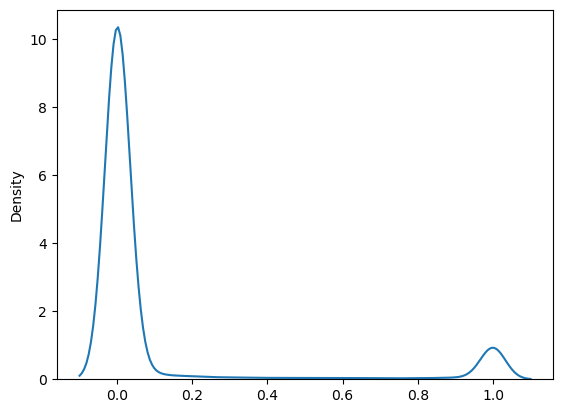

In [8]:
# Histogram of missingness
raw_data_copy = raw_data.copy()
missingness = raw_data_copy.isna().sum(axis=1)/len(raw_data_copy.columns)
sns.kdeplot(missingness)

It looks like we would benefit from excluding all genes that have greater than 5% missingness. The values with 100% missingness are actually values associated with the experimental probes (not gene expression) and therefore are not a concern. 

In [9]:
# Dropping genes that have more than 70% missingness

raw_data_trans = raw_data.transpose()
raw_data_drop = raw_data.iloc[np.where(raw_data_trans.isna().sum()/len(raw_data.columns) < 0.05)]
raw_data_trans = raw_data_drop.transpose()

In [10]:
print(raw_data_trans.shape)

(202, 38429)


This brought our # of genes from ~44,000 to ~38,000.

In [11]:
# Merging expression values with the condition of the sample

expression_data = raw_data_trans.merge(raw_metadata, left_index=True, right_index=True)
expression_data = expression_data.set_index("Condition")

There are duplicate genes in this dataset which indicate different isoforms/splice variants. To fix this, we are adding suffixes to duplicated genes so we can uniquely identify them.

In [12]:
# Credit to Glen Thompson on StackOverflow for the df_column_uniquify method!
# https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns

def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}.{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

expression_data = df_column_uniquify(expression_data)

In [13]:
# Our classifier cannot have missing values, so for the remaining missing values, we will replace them with the average value for that gene
# within each target class, assuming that the condition is the only factor that would change gene expression between samples. 

avg_expression = expression_data.groupby("Condition").mean()
ex_index = expression_data.index

def fill_missing(group):
    group = group.fillna(avg_expression)
    return group
    
expression_data = expression_data.groupby("Condition").apply(fill_missing).reset_index(drop=True).set_index(ex_index)

In [14]:
# We need to remove most of these genes to prevent overfitting. We will try different models with 50 genes, 100 genes, and 500 genes 
# to see which gives the most accurate classification. We will do so with a PCA

model = pca(n_components=100)
results = model.fit_transform(expression_data)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [38429] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[100]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


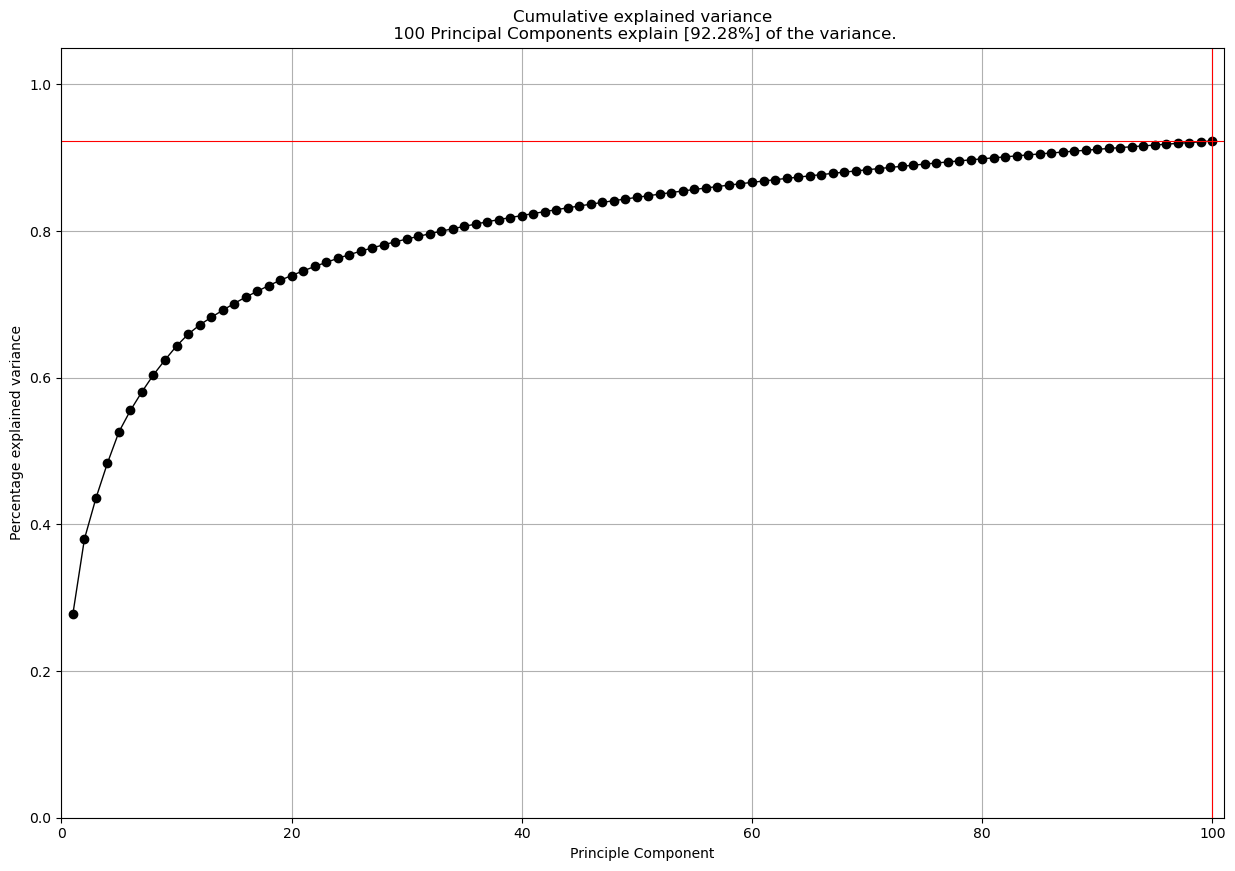

In [15]:
fig, ax = model.plot()

In [16]:
best_features = results['topfeat'].iloc[np.where(results['topfeat'].type == "best")].feature
expression_data_top = expression_data.loc[:, best_features]

---
## EDA

In [17]:
# Summarize the data
expression_data_top.describe()

,A_32_P188694,CXCL1,MTTP,AKAP12.1,S100P,CLDN8,SAA1,A_23_P435390,CLDN8,FAM3B,...,KANSL1-AS1,A_32_P171427,DMBT1,A_32_P171427,BC006271,GLDN.1,FAM3B,MCOLN2,CYR61.1,BTNL8
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,...,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,0.683031,0.043093,-0.447108,0.388942,0.252702,0.675680,0.224722,-0.480330,0.675680,0.176229,...,0.142721,-0.088503,1.383023,-0.088503,0.014161,0.188116,0.176229,0.649162,-0.806048,1.432825
std,0.529284,0.636824,0.522524,0.621652,0.580542,0.612264,0.577707,0.445818,0.612264,0.573044,...,0.244382,0.370179,0.453063,0.370179,0.335252,0.506175,0.573044,0.375391,0.549543,0.425418
min,-0.085672,-0.766250,-0.962110,-0.641430,-0.989540,-0.291370,-0.539530,-1.204900,-0.291370,-0.404540,...,-0.306830,-1.289700,0.201570,-1.289700,-0.627530,-0.728770,-0.404540,-0.233020,-1.657800,-0.099335
25%,0.228840,-0.383640,-0.671580,-0.124465,-0.181803,0.131470,-0.189530,-0.806755,0.131470,-0.243028,...,-0.047993,-0.417480,1.040825,-0.417480,-0.262807,-0.201305,-0.243028,0.377290,-1.265875,1.399500
50%,0.633425,-0.160650,-0.560355,0.295295,0.218510,0.582233,0.004406,-0.565685,0.582233,-0.109970,...,0.096123,-0.028538,1.335850,-0.028538,-0.059191,0.103540,-0.109970,0.687195,-0.906030,1.553150
75%,1.011775,0.248145,-0.444632,0.723283,0.724980,1.200425,0.525033,-0.278773,1.200425,0.546347,...,0.323095,0.196830,1.815250,0.196830,0.320667,0.554427,0.546347,0.937277,-0.468420,1.646100
max,2.000000,2.000000,2.000000,2.000000,1.376700,2.000000,1.859400,1.186400,2.000000,1.601200,...,0.903470,0.615770,2.000000,0.615770,0.766900,1.392400,1.601200,1.489300,0.895530,2.000000


In [18]:
# Dispaly target variable counts
print("Target Variable Counts:")
expression_data_top.index.value_counts()

Target Variable Counts:


Condition
UC        129
Normal     73
Name: count, dtype: int64

In [19]:
# Means of each gene grouped by target value
print("Gene Expression Means:")
display(expression_data_top.groupby(expression_data_top.index).mean())

Gene Expression Means:


,A_32_P188694,CXCL1,MTTP,AKAP12.1,S100P,CLDN8,SAA1,A_23_P435390,CLDN8,FAM3B,...,KANSL1-AS1,A_32_P171427,DMBT1,A_32_P171427,BC006271,GLDN.1,FAM3B,MCOLN2,CYR61.1,BTNL8
Condition,,,,,,,,,,,,,,,,,,,,,
Normal,0.624579,-0.204489,-0.363566,0.471700,0.001347,0.849394,-0.063834,-0.610203,0.849394,0.153077,...,0.101095,-0.118209,1.213378,-0.118209,-0.007174,0.239736,0.153077,0.617573,-0.941042,1.399799
UC,0.716108,0.183197,-0.494383,0.342109,0.394941,0.577377,0.388013,-0.406836,0.577377,0.189330,...,0.166276,-0.071693,1.479024,-0.071693,0.026234,0.158904,0.189330,0.667038,-0.729656,1.451515


In [20]:
# EDA Plot Ideas
# - Plot distribution of UC and Normal (Target Classes)
# - Select a few of the best genes and plot their distribution of UC and Normal
# - heatmap of correlation matrix between subset of most influential genes

In [21]:
expression_data_top.head()

,A_32_P188694,CXCL1,MTTP,AKAP12.1,S100P,CLDN8,SAA1,A_23_P435390,CLDN8,FAM3B,...,KANSL1-AS1,A_32_P171427,DMBT1,A_32_P171427,BC006271,GLDN.1,FAM3B,MCOLN2,CYR61.1,BTNL8
Condition,,,,,,,,,,,,,,,,,,,,,
Normal,0.37469,-0.259980,-0.63535,0.698060,0.090826,1.6946,-0.268180,-0.811250,1.6946,-0.23232,...,-0.062057,-0.510760,0.88732,-0.510760,-0.41575,1.17770,-0.23232,0.97205,0.016635,1.65050
Normal,0.24778,0.002733,-0.40935,0.356290,0.915640,1.9320,-0.285860,-0.660940,1.9320,-0.24318,...,-0.001755,-0.580760,0.70511,-0.580760,0.15535,1.12880,-0.24318,1.08370,-0.811220,0.10839
Normal,0.37463,-0.223740,-0.37649,0.250840,0.144740,1.2422,0.041565,-1.067500,1.2422,-0.26024,...,0.098703,-0.047013,1.02530,-0.047013,0.42294,0.36373,-0.26024,0.21393,-0.497180,1.69520
Normal,0.29446,-0.189810,-0.53817,0.156970,-0.269840,1.2100,-0.189650,-0.374790,1.2100,-0.28423,...,0.093543,0.310840,1.12060,0.310840,0.61817,0.53559,-0.28423,0.59093,-1.091100,1.66360
Normal,0.14230,-0.036116,-0.54970,-0.027901,-0.226840,1.4371,-0.189170,0.059439,1.4371,-0.30920,...,0.074669,0.187240,1.08800,0.187240,0.76690,0.54085,-0.30920,0.65648,-0.913690,1.67880


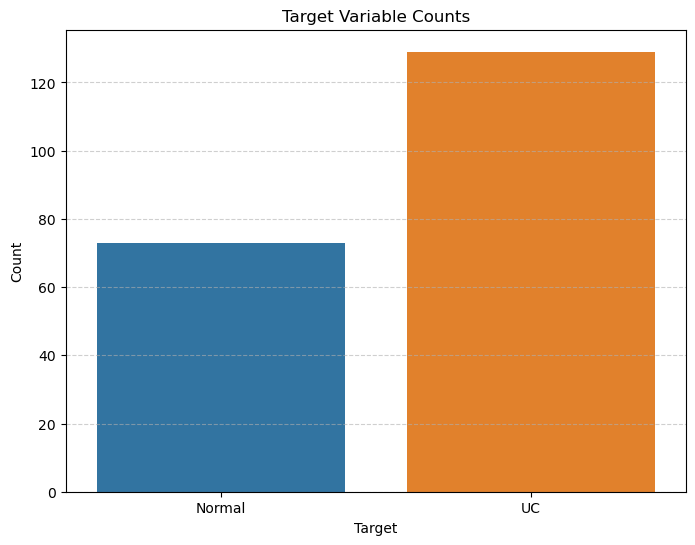

In [22]:
 # Barchart of the target variable counts
plt.figure(figsize=(8, 6))
sns.countplot(data=expression_data_top, x=expression_data_top.index)
plt.title('Target Variable Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Best Genes: ['A_32_P188694', 'CXCL1', 'MTTP', 'AKAP12.1', 'S100P', 'CLDN8', 'SAA1', 'A_23_P435390', 'CLDN8', 'FAM3B']


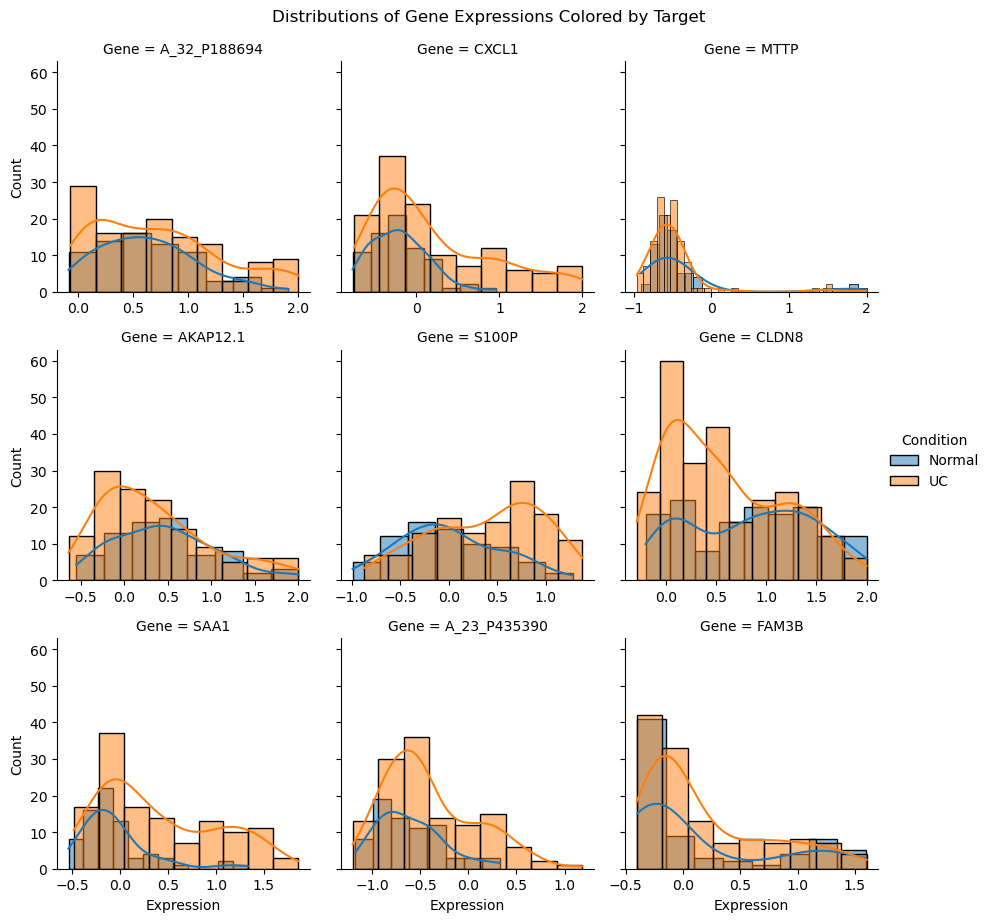

In [23]:
# Take a small sample of the best genes and plot their distributions over target classes (UC and Normal)
best_genes = expression_data_top.iloc[:, 0:10]  # Take first 10 genes
print("Best Genes:", list(best_genes.columns))

# Make condition a column
best_genes.reset_index(inplace=True)

# Melt best genes
best_genes_melt = best_genes.melt(id_vars='Condition', var_name="Gene", value_name="Expression")
best_genes_melt.head()

g = sns.FacetGrid(best_genes_melt, col='Gene', col_wrap=3, hue='Condition', sharex=False)
g.map(sns.histplot, 'Expression', kde=True, alpha=0.5)
g.add_legend()
g.figure.suptitle('Distributions of Gene Expressions Colored by Target', y=1.02)
plt.show()

## There are repeated columns (genes) in expression_data_top??

In [24]:
best_genes

,Condition,A_32_P188694,CXCL1,MTTP,AKAP12.1,S100P,CLDN8,SAA1,A_23_P435390,CLDN8,FAM3B
0,Normal,0.37469,-0.259980,-0.63535,0.698060,0.090826,1.69460,-0.268180,-0.811250,1.69460,-0.23232
1,Normal,0.24778,0.002733,-0.40935,0.356290,0.915640,1.93200,-0.285860,-0.660940,1.93200,-0.24318
2,Normal,0.37463,-0.223740,-0.37649,0.250840,0.144740,1.24220,0.041565,-1.067500,1.24220,-0.26024
3,Normal,0.29446,-0.189810,-0.53817,0.156970,-0.269840,1.21000,-0.189650,-0.374790,1.21000,-0.28423
4,Normal,0.14230,-0.036116,-0.54970,-0.027901,-0.226840,1.43710,-0.189170,0.059439,1.43710,-0.30920
...,...,...,...,...,...,...,...,...,...,...,...
197,UC,0.46518,0.805780,-0.69966,-0.240630,-0.238060,0.23171,0.931780,-0.043835,0.23171,1.07050
198,UC,0.77049,-0.405080,-0.53996,0.105370,0.974470,0.25006,0.271400,-0.644370,0.25006,0.87362
199,UC,1.06670,-0.333020,0.13385,0.252540,0.699530,0.17170,0.493360,-0.437820,0.17170,0.56317
200,UC,0.48161,0.250370,-0.72470,-0.198490,-0.226820,0.13929,0.695300,-0.093775,0.13929,0.66513


In [25]:
# Get correlation matrix
correlation_matrix = best_genes.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pairwise Correlation Heatmap of Top Genes')
plt.show()

ValueError: could not convert string to float: 'Normal'

In [ ]:
# Different selection of 10 genes
# Find 5 genes each from UC and Normal, that are most different from one another



In [ ]:
print(sns.__version__)

0.12.2
